# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.
Работа Гринева Артема
### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [1]:
import pandas as pd
import numpy as np

In [2]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [3]:
!pip install datatable

In [4]:
!pip install rs-datasets

In [5]:
from rs_datasets import MovieLens

In [6]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [8]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


### Активность пользователем

In [9]:
import matplotlib.pyplot as plt

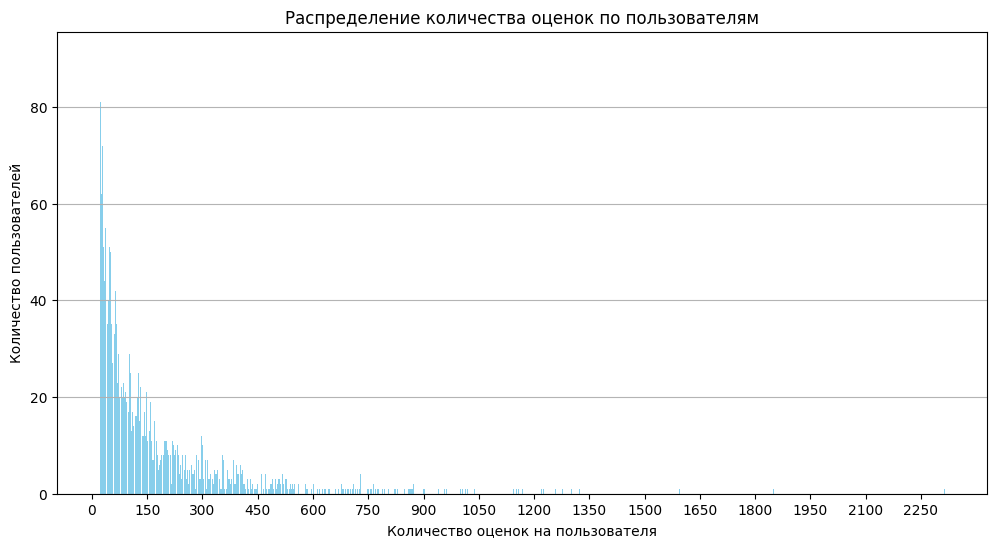


Среднее количество оценок на пользователя: 165.5975165562914


In [10]:
ratings_data = data.ratings

# Подсчет общего количества оценок, оставленных каждым пользователем
user_rating_counts = ratings_data['user_id'].value_counts()

# Распределение количества оценок по пользователям
user_rating_counts_distribution = user_rating_counts.value_counts().sort_index()

# Определение среднего количества оценок на пользователя
average_ratings_per_user = user_rating_counts.mean()

# Построение гистограммы
plt.figure(figsize=(12, 6))
plt.bar(user_rating_counts_distribution.index, user_rating_counts_distribution.values, color='skyblue')
plt.xlabel('Количество оценок на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества оценок по пользователям')
plt.grid(axis='y', alpha=0.95)
x_ticks = range(0, user_rating_counts_distribution.index.max(), 150)
plt.xticks(x_ticks)
plt.show()

# Вывод среднего количества оценок на пользователя
print("\nСреднее количество оценок на пользователя:", average_ratings_per_user)

### Анализ фильмов

#### Активность фильмов

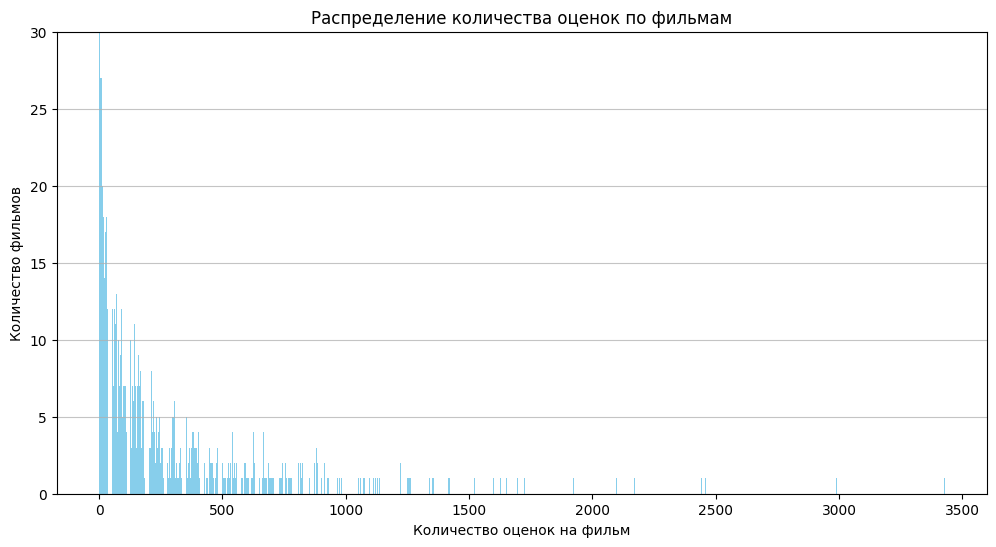


Среднее количество оценок на фильм: 269.88909875876953


In [11]:
ratings_data = data.ratings

# Подсчет общего количества оценок, полученных каждым фильмом
movie_rating_counts = ratings_data['item_id'].value_counts()

# Распределение количества оценок по фильмам
movie_rating_counts_distribution = movie_rating_counts.value_counts().sort_index()

# Определение среднего количества оценок на фильм
average_ratings_per_movie = movie_rating_counts.mean()

# Построение гистограммы
plt.figure(figsize=(12, 6))
plt.bar(movie_rating_counts_distribution.index, movie_rating_counts_distribution.values, color='skyblue')
plt.xlabel('Количество оценок на фильм')
plt.ylabel('Количество фильмов')
plt.title('Распределение количества оценок по фильмам')
plt.grid(axis='y', alpha=0.75)
plt.ylim(top=30) 
plt.show()

# Вывод среднего количества оценок на фильм
print("\nСреднее количество оценок на фильм:", average_ratings_per_movie)

#### Преобладающие оценки

In [12]:
ratings_data

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


Распределение оценок:


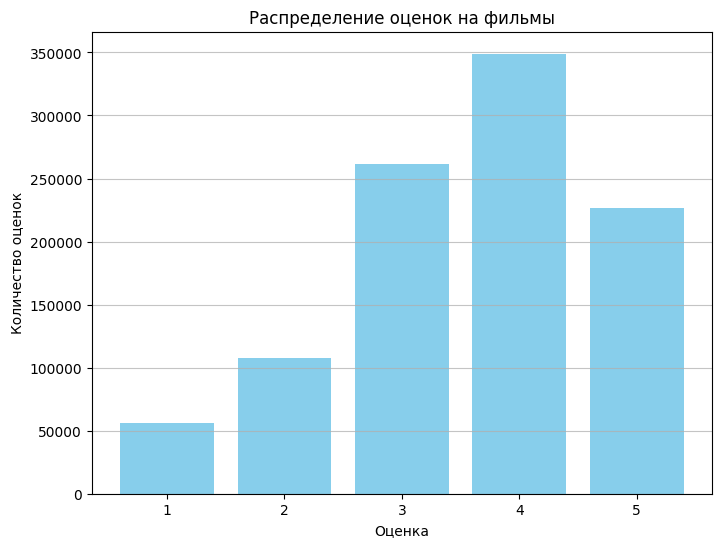


Средняя оценка: 3.581564453029317


In [13]:
# Подсчет распределения оценок
rating_distribution = ratings_data['relevance'].value_counts().sort_index()

# Определение средней оценки
average_rating = ratings_data['relevance'].mean()

# Вывод распределения оценок и средней оценки
print("Распределение оценок:")
#print(rating_distribution)

plt.figure(figsize=(8, 6))
plt.bar(rating_distribution.index, rating_distribution.values, color='skyblue')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.title('Распределение оценок на фильмы')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rating_distribution.index)

plt.show()

print("\nСредняя оценка:", average_rating)

#### Изменение количества оценок во времени

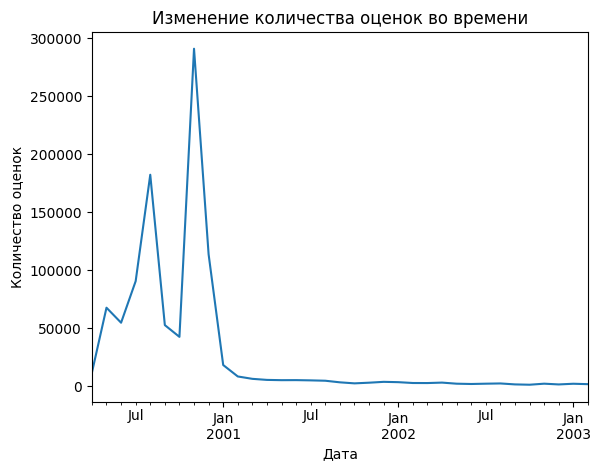

In [14]:
# Построение графика изменения количества оценок во времени
ratings_data.set_index('timestamp').resample('M').size().plot()
plt.xlabel('Дата')
plt.ylabel('Количество оценок')
plt.title('Изменение количества оценок во времени')
plt.show()

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [15]:
ratings_data = data.ratings

# Разделение данных на обучающий и валидационный наборы
train = ratings_data[ratings_data['timestamp'] < '2000-12-01']
val = ratings_data[(ratings_data['timestamp'] >= '2000-12-01') & (ratings_data['timestamp'] <= '2000-12-31')]
val = val[val['relevance'] > 3]

# Удаление холодных пользователей из валидационного набора
cold_users = set(val['user_id']) - set(train['user_id'])
val = val[~val['user_id'].isin(cold_users)]

# Вывод информации о размерах обучающего и валидационного наборов
print("Размер обучающего набора:", train.shape)
print("Размер валидационного набора:", val.shape)

Размер обучающего набора: (791270, 4)
Размер валидационного набора: (14790, 4)


In [16]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [17]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [18]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [19]:
%%time
# YOUR CODE HERE
validation_users = val['user_id'].unique()

recommendations = []

# Для каждого пользователя из валидационного набора
for user_id in validation_users:
    # Генерация 20 случайных фильмов
    random_movies = np.random.choice(train['item_id'].unique(), 20, replace=False)
    
    # Генерация случайного скора (релевантности) для каждого фильма
    relevance_scores = np.random.randint(1, 6, 20)  # Генерация случайных значений от 1 до 5
    
    # Добавление рекомендаций в список
    for movie_id, relevance in zip(random_movies, relevance_scores):
        recommendations.append({'user_id': user_id, 'item_id': movie_id, 'relevance': relevance})

random_pred = pd.DataFrame(recommendations)
random_pred = random_pred.sort_values(by=['user_id', 'relevance'], ascending=[True, False])
print(random_pred.head(20))

    user_id  item_id  relevance
5       670     2534          5
6       670     3566          5
8       670     3889          5
14      670     2793          5
0       670     3623          4
1       670     2718          4
4       670     3220          4
9       670     2760          4
15      670     2397          4
18      670     3809          4
7       670      352          3
10      670     2619          3
12      670      439          3
13      670     3032          3
19      670     3270          3
2       670     2152          2
3       670     3103          2
11      670      339          2
17      670     2000          2
16      670     2393          1
CPU times: total: 3.38 s
Wall time: 3.4 s


In [20]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [21]:
random_pred.head(1)

,user_id,item_id,relevance
5,670,2534,5


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [22]:
import math

In [23]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    pred_list = row['pred_list'][:k]  # Top-K предсказанных элементов
    gt_list = row['gt_list']  # Фактические элементы из тестового набора

    def dcg_at_k(scores, k):
        return np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))
    
    # Создание списков релевантностей для предсказанных и фактических элементов
    relevance_scores = [1 if item in gt_list else 0 for item in pred_list]
    ideal_scores = [1] * min(len(gt_list), k)  # Идеальные релевантности для IDCG@K
    #print(ideal_scores)

    # Вычисление DCG@K и IDCG@K
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(ideal_scores, k)
    #print(dcg)
    #print(idcg)
    
    # Вычисление NDCG@K
    if idcg == 0:
        ndcg = 0  
    else:
        ndcg = dcg / idcg
        
    return ndcg

In [24]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [25]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3

# Сортировка данных по пользователям и столбцу релевантности
ratings_data_sorted = train.sort_values(by=['user_id', 'relevance'], ascending=[True, False])

# Вывод первых строк отсортированной таблицы для проверки
print(ratings_data_sorted.head(20))

        user_id  item_id  relevance           timestamp
100423      670     3030          5 2000-11-30 23:54:01
100428      670      912          5 2000-11-30 23:49:54
100431      670      923          5 2000-11-30 23:49:23
100443      670     3435          5 2000-11-30 23:49:54
100445      670     3468          5 2000-11-30 23:54:01
100456      670      608          5 2000-11-30 23:52:33
100459      670     1148          5 2000-11-30 23:49:54
100471      670     3362          5 2000-11-30 23:54:01
100474      670     2731          5 2000-11-30 23:52:33
100475      670     1952          5 2000-11-30 23:52:09
100476      670       30          5 2000-11-30 23:52:32
100484      670     1207          5 2000-11-30 23:51:29
100494      670     1230          5 2000-11-30 23:50:34
100411      670     1252          4 2000-11-30 23:52:33
100412      670      720          4 2000-11-30 23:51:54
100416      670     3949          4 2000-11-30 23:57:50
100425      670      904          4 2000-11-30 2

In [26]:
# Группировка данных из random_pred по user_id и формирование списка предсказанных элементов
pred_grouped = random_pred.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id': 'pred_list'})

# Группировка данных из ratings_data_sorted по user_id и формирование списка элементов из тестовых данных
gt_grouped = ratings_data_sorted.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id': 'gt_list'})

In [27]:
final_data = pd.merge(pred_grouped, gt_grouped, on='user_id')
final_data.head()

,user_id,pred_list,gt_list
0,670,"[2534, 3566, 3889, 2793, 3623, 2718, 3220, 276...","[3030, 912, 923, 3435, 3468, 608, 1148, 3362, ..."
1,671,"[355, 1011, 1529, 3384, 2510, 3067, 3937, 2923...","[750, 903, 904, 1292, 912, 922, 924, 296, 608,..."
2,673,"[2752, 2707, 3805, 1485, 2616, 3717, 3066, 226...","[1249, 1250, 1251, 1406, 3949, 3010, 1411, 127..."
3,674,"[2350, 1047, 1826, 1677, 2591, 224, 815, 273, ...","[1266, 2073, 750, 908, 924, 1610, 3256, 1653, ..."
4,676,"[514, 1409, 2163, 667, 1785, 1079, 2375, 1391,...","[260, 1270, 480, 3361, 1617, 3257]"


In [28]:
final_data['ndcg'] = final_data.apply(lambda row: ndcg_user(row, k=20), axis=1)
final_data.head(20)

,user_id,pred_list,gt_list,ndcg
0,670,"[2534, 3566, 3889, 2793, 3623, 2718, 3220, 276...","[3030, 912, 923, 3435, 3468, 608, 1148, 3362, ...",0.000000
1,671,"[355, 1011, 1529, 3384, 2510, 3067, 3937, 2923...","[750, 903, 904, 1292, 912, 922, 924, 296, 608,...",0.000000
2,673,"[2752, 2707, 3805, 1485, 2616, 3717, 3066, 226...","[1249, 1250, 1251, 1406, 3949, 3010, 1411, 127...",0.000000
3,674,"[2350, 1047, 1826, 1677, 2591, 224, 815, 273, ...","[1266, 2073, 750, 908, 924, 1610, 3256, 1653, ...",0.000000
4,676,"[514, 1409, 2163, 667, 1785, 1079, 2375, 1391,...","[260, 1270, 480, 3361, 1617, 3257]",0.000000
5,678,"[3424, 3658, 2852, 229, 2809, 2219, 2581, 3470...","[1, 3408, 2692, 2858, 3844, 3114, 2333, 1721, ...",0.000000
6,687,"[2779, 29, 418, 977, 1463, 2414, 1044, 2796, 1...","[2997, 589, 1265, 593, 1449, 3418, 2628, 3481,...",0.000000
7,688,"[1886, 2576, 2977, 2236, 3776, 15, 2640, 1189,...","[1278, 1193, 1196, 2028, 2670, 2729, 3701]",0.000000
8,692,"[2292, 2621, 3800, 3539, 1604, 1553, 3293, 687...","[1617, 1193, 2433, 1729, 174]",0.000000
9,693,"[1964, 3952, 550, 2437, 851, 2286, 3230, 404, ...","[589, 736, 593, 1288, 1291, 1293, 1296, 1299, ...",0.000000


In [29]:
average_ndcg = final_data['ndcg'].mean()
print("Average NDCG: ", average_ndcg)

Average NDCG:  0.05813077720889982


### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [30]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.log = log
        self.N = log['user_id'].nunique()
        self.item_info = self.calculate_item_info()

    def calculate_item_info(self):
        item_interactions = self.log.groupby('item_id')['user_id'].nunique().reset_index()
        item_interactions.columns = ['item_id', 'num_users']
        item_interactions['self_info'] = -np.log2(item_interactions['num_users'] / self.N)
        return item_interactions.set_index('item_id')['self_info']

    def __call__(self, pred, k):
        def user_surprisal(user_pred):
            top_k_items = user_pred['pred_list'][:k]              
            return sum(self.item_info.get(item, -np.log2(1 / self.N)) for item in top_k_items) / (k * np.log2(self.N)) # -np.log2(1 / self.N) Холодные item-ы
        
        # Группировка по user_id и создание списка item_id для каждого пользователя
        pred_grouped = pred.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id': 'pred_list'})
        user_surprisal_values = []
        for index, row in pred_grouped.iterrows():
            user_surprisal_value = user_surprisal(row)
            user_surprisal_values.append(user_surprisal_value)
            
        #print(np.mean(user_surprisal_values))
        return np.mean(user_surprisal_values)

In [31]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [32]:
# YOUR CODE HERE: оценка 4 метрик для рекомендаций из задания 3

In [33]:
surp = Surprisal(ratings_data_sorted)
surprisal_score = surp(random_pred, K)
print("Surprisal score for random predictions:", surprisal_score)

Surprisal score for random predictions: 0.502482628303648


#### HitRate

In [34]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

#### Coverage

In [35]:
def coverage(pred, k, all_items=train['item_id']):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

In [36]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [37]:
def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [38]:
hit_rate = metric_wrap(pred=random_pred, ground_truth=ratings_data_sorted, k=K, metric_by_user=user_hr)[0]
coverage_ = coverage(pred=random_pred, k=K)
print('Hit rate: ', hit_rate)
print('Coverage: ', coverage_)

Hit rate:  0.05424044734389562
Coverage:  0.9404696886947024


#### Функция, которая генерирует словарь с метриками

In [39]:
def evaluate_metrics(pred, data_sorted, K):
    # Группировка данных из pred по user_id и формирование списка предсказанных элементов
    pred_grouped = pred.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id': 'pred_list'})

    # Группировка данных из data_sorted по user_id и формирование списка элементов из тестовых данных
    gt_grouped = data_sorted.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id': 'gt_list'})
    
    final_data = pd.merge(pred_grouped, gt_grouped, on='user_id')
    
    # Вычисление NDCG
    final_data['ndcg'] = final_data.apply(lambda row: ndcg_user(row, k=K), axis=1)
    average_ndcg = final_data['ndcg'].mean()
    
    # Вычисление Surprisal
    surp = Surprisal(data_sorted)
    surprisal_score = surp(pred, K)
    
    # Вычисление Hit Rate
    hit_rate = metric_wrap(pred=pred, ground_truth=data_sorted, k=K, metric_by_user=user_hr)[0]
    
    # Вычисление Coverage
    coverage_ = coverage(pred=pred, k=K)
    
    # Создание словаря с метриками
    metrics_dict = {
        'NDCG': average_ndcg,
        'Surprisal': surprisal_score,
        'Hit Rate': hit_rate,
        'Coverage': coverage_
    }
    
    return metrics_dict

#### Для Train

In [40]:
# Пример использования функции для оценки baseline-решения на валидации
metrics_result = evaluate_metrics(random_pred, ratings_data_sorted, K)
print(metrics_result)

{'NDCG': 0.05813077720889982, 'Surprisal': 0.502482628303648, 'Hit Rate': 0.05424044734389562, 'Coverage': 0.9404696886947024}


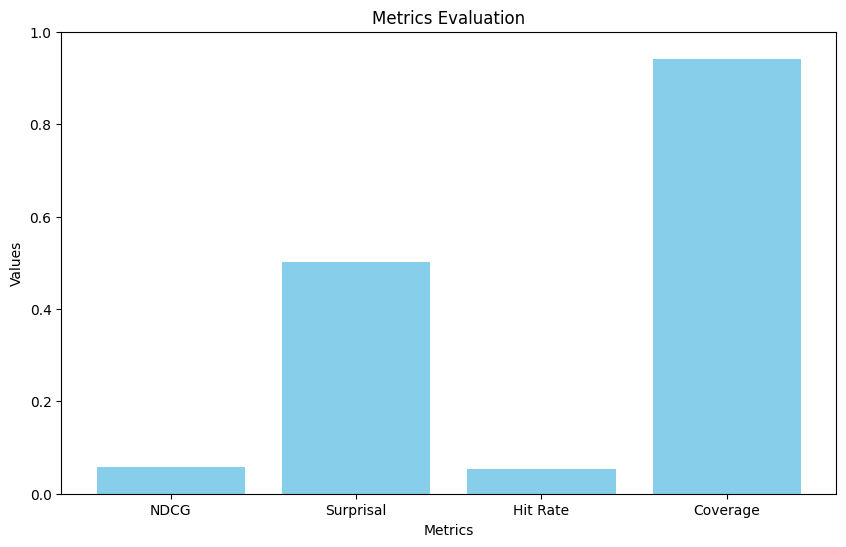

In [41]:
metrics_df = pd.DataFrame.from_dict(metrics_result, orient='index', columns=['Value'])
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Metric'}, inplace=True)

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Evaluation')
plt.ylim(0, 1) 
plt.show()

#### Для Val

In [42]:
ratings_val_data_sorted = val.sort_values(by=['user_id', 'relevance'], ascending=[True, False])

In [43]:
# Пример использования функции для оценки baseline-решения на валидации
metrics_result = evaluate_metrics(random_pred, ratings_val_data_sorted, K)
print(metrics_result)

{'NDCG': 0.007461049119318149, 'Surprisal': 0.8639720918541696, 'Hit Rate': 0.11494252873563218, 'Coverage': 0.9404696886947024}


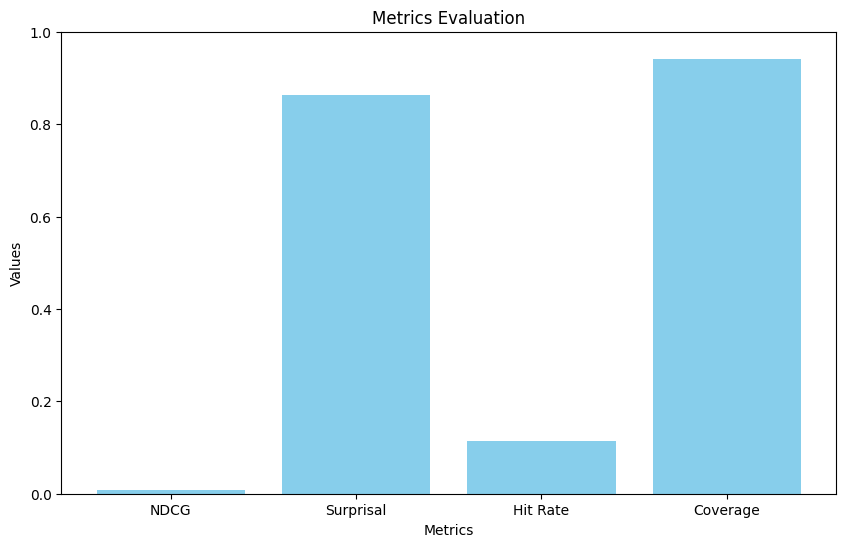

In [44]:
metrics_df = pd.DataFrame.from_dict(metrics_result, orient='index', columns=['Value'])
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Metric'}, inplace=True)

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Evaluation')
plt.ylim(0, 1) 
plt.show()

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [45]:
! pip install implicit

In [46]:
train.head()

,user_id,item_id,relevance,timestamp
100409,670,3935,3,2000-11-30 23:49:23
100411,670,1252,4,2000-11-30 23:52:33
100412,670,720,4,2000-11-30 23:51:54
100415,670,3948,1,2000-11-30 23:58:06
100416,670,3949,4,2000-11-30 23:57:50


In [47]:
train['relevance'] = train['relevance'].astype(float)
train = train.drop('timestamp', axis=1)

C:\Users\Empty\AppData\Local\Temp\ipykernel_13564\2567158199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype(float)


In [82]:
from collections import defaultdict
from scipy.sparse import csr_matrix, dok_matrix
user_num = train["user_id"].max() + 1
item_num = train["item_id"].max() + 1

train_mat = defaultdict(float)
for _, user, item, rel in train[["user_id", "item_id", "relevance"]].itertuples():
    train_mat[user, item] = rel
rating_matrix = dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(rating_matrix, train_mat)

In [49]:
from implicit.nearest_neighbours import CosineRecommender
model = CosineRecommender(K = 20)
model.fit(rating_matrix)

i:\Проекты\jirafe\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03902602195739746 seconds
  warnings.warn(
100%|██████████| 3953/3953 [00:00<00:00, 21362.81it/s]


In [50]:
users_list = train['user_id'].unique()
ids, scores = model.recommend(users_list, csr_matrix(rating_matrix[users_list]), 20)

In [51]:
recommendations = []
for i, user_id in enumerate(users_list):
    for j in range(len(ids[i])):
        recommendations.append([user_id, ids[i][j], scores[i][j]])

In [52]:
recommendations_df = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
recommendations_df.head()

,user_id,item_id,relevance
0,670,1247,29.091484
1,670,858,26.629059
2,670,908,22.294863
3,670,903,19.798117
4,670,750,17.594332


In [53]:
metrics_results = evaluate_metrics(recommendations_df, val, 20)

In [54]:
metrics_results

{'NDCG': 0.12880935695065115,
 'Surprisal': 0.5086480758593466,
 'Hit Rate': 0.49616858237547895,
 'Coverage': 0.2528672856362643}

In [55]:
k_values =  [5, 10, 15, 20, 30, 50]  # Пример значений K для оценки
metrics_results = {}
for k in k_values:
    model = CosineRecommender(K=k)
    model.fit(rating_matrix)
    users_list = train['user_id'].unique()
    ids, scores = model.recommend(users_list, csr_matrix(rating_matrix[users_list]), k)
    recommendations = []
    for i, user_id in enumerate(users_list):
        for j in range(len(ids[i])):
            recommendations.append([user_id, ids[i][j], scores[i][j]])
    recommendations_df = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_results[k] = evaluate_metrics(recommendations_df, val, k)


i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03900885581970215 seconds
  warnings.warn(
100%|██████████| 3953/3953 [00:00<00:00, 24395.68it/s]
i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03937268257141113 seconds
  warnings.warn(
100%|██████████| 3953/3953 [00:00<00:00, 23807.97it/s]
i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03800845146179199 seconds
  warnings.warn(
100%|██████████| 3953/3953 [00:00<00:00, 25013.36it/s]
i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.038007259368896484 seconds

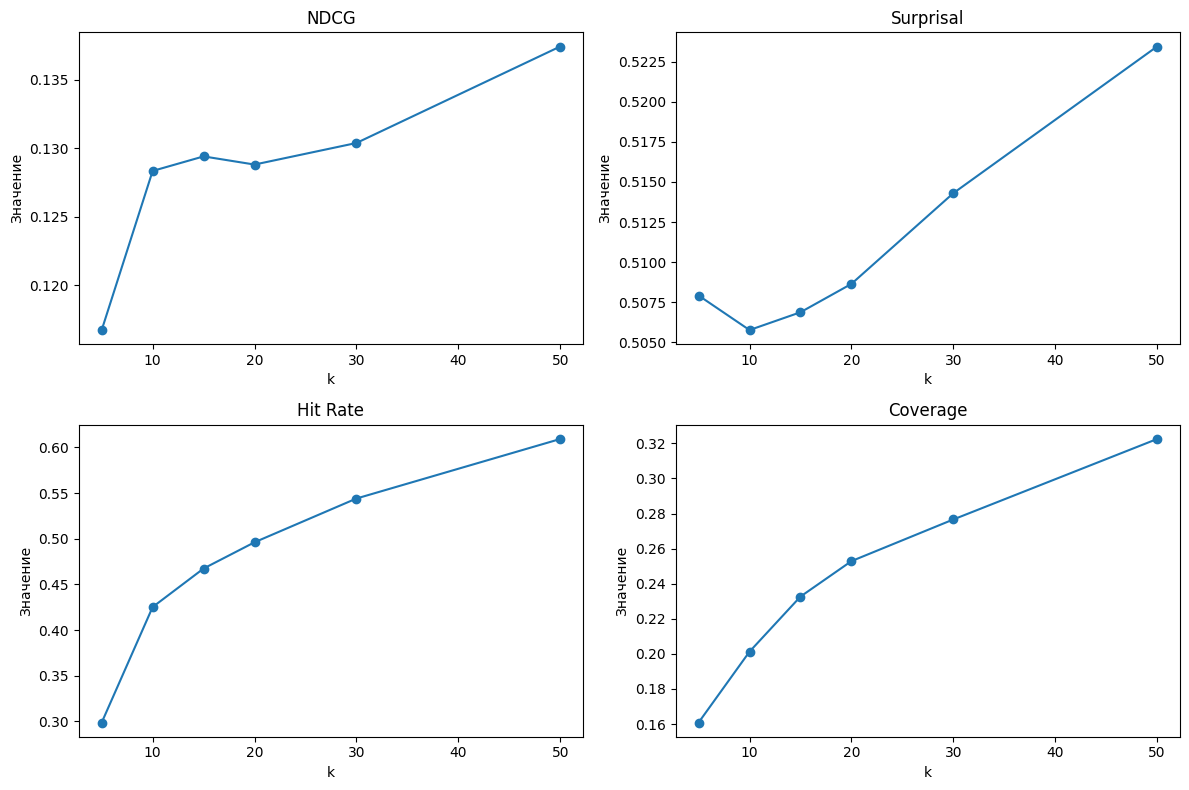

In [56]:
# Данные для каждой метрики
NDCG = [metrics_results[k]['NDCG'] for k in k_values]
Surprisal_m = [metrics_results[k]['Surprisal'] for k in k_values]
Hit_Rate = [metrics_results[k]['Hit Rate'] for k in k_values]
Coverage = [metrics_results[k]['Coverage'] for k in k_values]

# Создание subplot
plt.figure(figsize=(12, 8))

# График для NDCG
plt.subplot(221)
plt.plot(k_values, NDCG, marker='o')
plt.title('NDCG')
plt.xlabel('k')
plt.ylabel('Значение')

# График для Surprisal
plt.subplot(222)
plt.plot(k_values, Surprisal_m, marker='o')
plt.title('Surprisal')
plt.xlabel('k')
plt.ylabel('Значение')

# График для Hit Rate
plt.subplot(223)
plt.plot(k_values, Hit_Rate, marker='o')
plt.title('Hit Rate')
plt.xlabel('k')
plt.ylabel('Значение')

# График для Coverage
plt.subplot(224)
plt.plot(k_values, Coverage, marker='o')
plt.title('Coverage')
plt.xlabel('k')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

#### F-IDF (Term Frequency-Inverse Document Frequency)

<strong>TF-IDF (Term Frequency-Inverse Document Frequency):</strong>

- При использовании TF-IDF в рекомендательной системе для музыки, каждый трек представляется как документ, а каждое слово или термин - как музыкальный тег или атрибут трека.

- TF-IDF будет учитывать, насколько часто определенные музыкальные теги встречаются в профиле пользователя по сравнению с их общим распределением по всей коллекции треков.

- Например, если пользователь часто слушает треки с тегами "рок" и "классика", но редко слушает треки с тегом "электроника", TF-IDF поможет выделить важность каждого из этих тегов при формировании персонализированных рекомендаций.


In [57]:
df_grouped = train.groupby('user_id').agg({'item_id': lambda x: ' '.join(map(str, x)),
                                        'relevance': lambda x: ' '.join(map(str, x))}).reset_index()

df_grouped

,user_id,item_id,relevance
0,670,3935 1252 720 3948 3949 2069 2075 2077 1280 20...,3.0 4.0 4.0 1.0 4.0 3.0 3.0 2.0 3.0 2.0 5.0 2....
1,671,3006 592 593 1272 750 903 904 1292 912 913 922...,4.0 3.0 4.0 4.0 5.0 5.0 5.0 5.0 5.0 4.0 5.0 5....
2,672,2987 3930 1250 1252 1259 589 590 1282 913 920 ...,4.0 4.0 5.0 4.0 4.0 3.0 5.0 3.0 5.0 4.0 3.0 5....
3,673,1249 1250 1251 3793 3794 724 1259 589 4 1401 3...,5.0 5.0 5.0 3.0 2.0 2.0 3.0 3.0 1.0 1.0 1.0 1....
4,674,1250 1259 589 6 1408 1266 590 593 1270 2073 12...,4.0 4.0 4.0 2.0 2.0 5.0 4.0 4.0 4.0 5.0 4.0 3....
...,...,...,...
5360,6036,571 574 2053 2054 2058 588 589 4 3005 6 3006 3...,3.0 3.0 2.0 3.0 2.0 2.0 5.0 2.0 2.0 3.0 4.0 5....
5361,6037,589 3006 1407 2064 2065 593 3015 903 904 905 9...,3.0 4.0 3.0 4.0 3.0 5.0 3.0 5.0 5.0 3.0 4.0 4....
5362,6038,1419 920 3088 232 1136 1148 1183 2146 3548 356...,4.0 3.0 5.0 4.0 4.0 5.0 5.0 4.0 4.0 4.0 4.0 5....
5363,6039,588 2067 1416 3022 3028 2080 2083 2087 3035 30...,4.0 4.0 4.0 4.0 3.0 4.0 3.0 3.0 4.0 5.0 3.0 4....


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_grouped['item_id'])
sparse_tfidf_matrix = csr_matrix(tfidf_matrix)
model = CosineRecommender(K=20)
model.fit(sparse_tfidf_matrix)

i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0400087833404541 seconds
  warnings.warn(
100%|██████████| 3653/3653 [00:00<00:00, 16377.49it/s]


In [59]:
user_id_to_recommend = 670
recommendations = model.recommend(user_id_to_recommend, sparse_tfidf_matrix)
recommendations

(array([ 243, 3551,  265,  221, 3413, 3508, 3571, 3058,  921,  244]),
 array([0.30493787, 0.24952405, 0.24649411, 0.24415541, 0.21695968,
        0.21521997, 0.21060422, 0.19461299, 0.19236011, 0.19213633]))

In [60]:
users_list = train['user_id'].unique()
ids, scores = model.recommend(users_list, sparse_tfidf_matrix)
recommendations = []
for i, user_id in enumerate(users_list):
    for j in range(len(ids[i])):
        recommendations.append([user_id, ids[i][j], scores[i][j]])
recommendations_df = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
recommendations_df

,user_id,item_id,relevance
0,670,243,0.304938
1,670,3551,0.249524
2,670,265,0.246494
3,670,221,0.244155
4,670,3413,0.216960
...,...,...,...
53645,6040,2520,0.328032
53646,6040,2277,0.299212
53647,6040,1834,0.283350
53648,6040,1238,0.267333


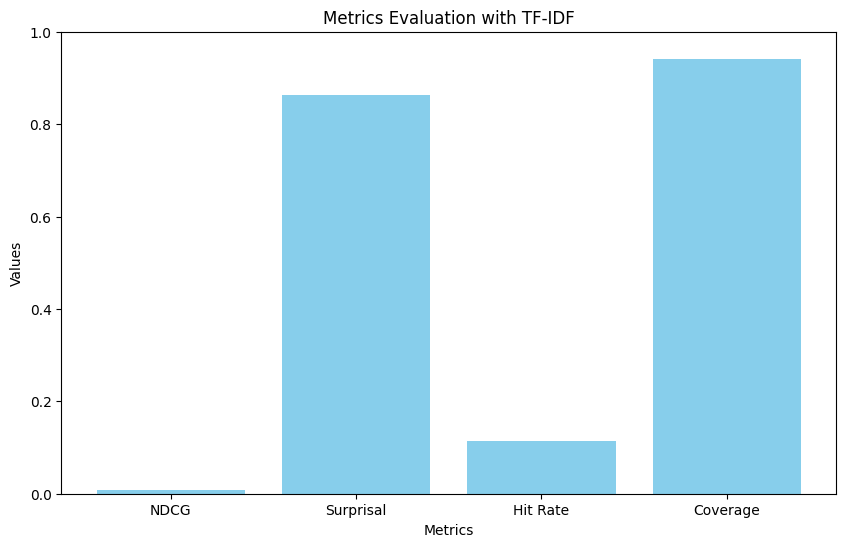

{'NDCG': 0.00481941565482036, 'Surprisal': 0.43463788401500797, 'Hit Rate': 0.05363984674329502, 'Coverage': 0.278809393773894}


In [61]:
metrics_results = evaluate_metrics(recommendations_df, val, 20)
metrics_df = pd.DataFrame.from_dict(metrics_result, orient='index', columns=['Value'])
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Metric'}, inplace=True)

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Evaluation with TF-IDF')
plt.ylim(0, 1) 
plt.show()
print(metrics_results)

<font color="green"><b>
Explanation:
</b></font>

При анализе графика метрик с использованием TF-IDF в CosineRecommender можно заметить, что результаты оказались ниже, чем при использовании стандартного CosineRecommender. Это может указывать на то, что применение TF-IDF в данном контексте не привело к улучшению качества рекомендаций.

Несмотря на то, что значения NDCG и Hit Rate оказались ниже, чем при использовании стандартного CosineRecommender, метрики Coverage и Surprisal показали повышение. Высокое значение метрики Coverage может указывать на более широкий охват рекомендаций для пользователей, в то время как увеличение Surprisal может свидетельствовать о более неожиданных и разнообразных рекомендациях.

Это противоречивое явление может быть связано с тем, что применение TF-IDF в данном контексте приводит к более широкому охвату и разнообразию рекомендаций за счет учета весов "слов", однако это может повлиять на точность и релевантность рекомендаций. 


#### train['relevance'] > 3

#### Так как данных с [train['relevance'] > 3] очень много, и по факты мы убрали довольно мало объектов, для наглядности мы будем обучать на [train['relevance'] > 4]

In [71]:
train_2 = train[train['relevance'] > 4]
user_num = train_2["user_id"].max() + 1
item_num = train_2["item_id"].max() + 1

train_mat = defaultdict(float)
for _, user, item, rel in train_2[["user_id", "item_id", "relevance"]].itertuples():
    train_mat[user, item] = rel
rating_matrix_2 = dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(rating_matrix_2, train_mat)

In [72]:
df_grouped_2 = train_2.groupby('user_id').agg({'item_id': lambda x: ' '.join(map(str, x)),
                                        'relevance': lambda x: ' '.join(map(str, x))}).reset_index()

df_grouped_2

,user_id,item_id,relevance
0,670,3030 912 923 3435 3468 608 1148 3362 2731 1952...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
1,671,750 903 904 1292 912 922 924 296 608 3683 1193...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
2,672,1250 590 913 969 457 1304 858 110 3334 1954 19...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
3,673,1249 1250 1251 1406 3949 3010 1411 1277 1280 7...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
4,674,1266 2073 750 908 924 1610 3256 1653 3421 260 ...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
...,...,...,...
5316,6036,589 3008 2064 593 594 3022 3028 3030 3034 903 ...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
5317,6037,593 903 904 910 924 926 928 3095 3471 260 296 ...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....
5318,6038,3088 1148 1183 1223 1296 1079,5.0 5.0 5.0 5.0 5.0 5.0
5319,6039,3037 903 904 913 916 918 922 926 3088 260 1125...,5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5....


In [73]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_grouped_2['item_id'])
sparse_tfidf_matrix = csr_matrix(tfidf_matrix)
model = CosineRecommender(K=20)
model.fit(sparse_tfidf_matrix)

i:\Проекты\jirafe\.conda\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007000923156738281 seconds
  warnings.warn(
100%|██████████| 3154/3154 [00:00<00:00, 126123.43it/s]


In [74]:
users_list = train_2['user_id'].unique()
ids, scores = model.recommend(users_list, sparse_tfidf_matrix)
recommendations = []
for i, user_id in enumerate(users_list):
    for j in range(len(ids[i])):
        recommendations.append([user_id, ids[i][j], scores[i][j]])
recommendations_df = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
recommendations_df

,user_id,item_id,relevance
0,670,226,0.342285
1,670,195,0.274352
2,670,803,0.226248
3,670,1078,0.210613
4,670,1934,0.189580
...,...,...,...
53205,6040,3027,0.135479
53206,6040,220,0.133080
53207,6040,1766,0.133023
53208,6040,186,0.131955


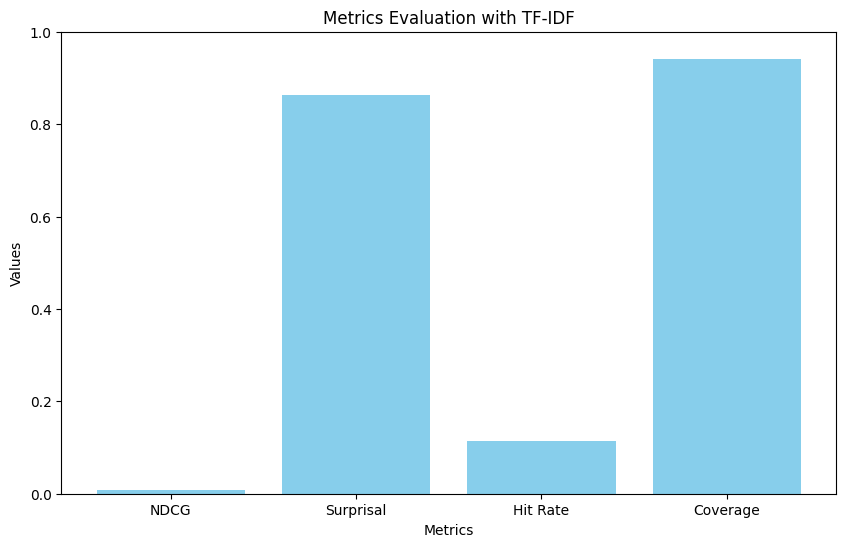

{'NDCG': 0.005366605774973388, 'Surprisal': 0.44188302535889, 'Hit Rate': 0.06321839080459771, 'Coverage': 0.5685417804478428}


In [75]:
metrics_results = evaluate_metrics(recommendations_df, val, 20)
metrics_df = pd.DataFrame.from_dict(metrics_result, orient='index', columns=['Value'])
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Metric'}, inplace=True)

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Evaluation with TF-IDF')
plt.ylim(0, 1) 
plt.show()
print(metrics_results)

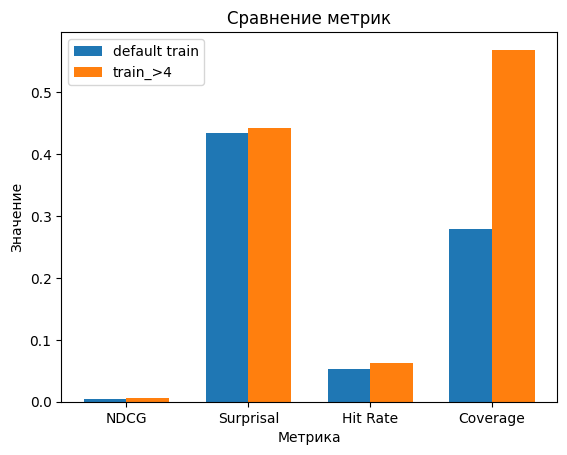

In [76]:
metrics = ['NDCG', 'Surprisal', 'Hit Rate', 'Coverage']
default_train = [0.00481941565482036, 0.43463788401500797, 0.05363984674329502, 0.278809393773894]
train_gt_4 = [0.005366605774973388, 0.44188302535889, 0.06321839080459771, 0.5685417804478428]

x = np.arange(len(metrics))  # Позиции для меток на оси X

fig, ax = plt.subplots()
bar_width = 0.35

# Создание гистограмм
rects1 = ax.bar(x - bar_width/2, default_train, bar_width, label='default train')
rects2 = ax.bar(x + bar_width/2, train_gt_4, bar_width, label='train_>4')

# Добавление меток, заголовков и т.д.
ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Отображение графика
plt.show()

Как мы видим, есть незначительные улучшения значений, хотя прирост Coverage был почти в два раза, что является хорошим показателем, с учетом того что в точности по другим метрикам мы не убавили

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

In [ ]:
val['relevance'] = val['relevance'].astype(float)
val = val.drop('timestamp', axis=1)

In [100]:
from collections import defaultdict
from scipy.sparse import csr_matrix, dok_matrix
user_num = train["user_id"].max() + 1
item_num = train["item_id"].max() + 1

train_mat = defaultdict(float)
for _, user, item, rel in train[["user_id", "item_id", "relevance"]].itertuples():
    train_mat[user, item] = rel
rating_matrix = dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(rating_matrix, train_mat)




user_num = val["user_id"].max() + 1
item_num = val["item_id"].max() + 1

train_mat = defaultdict(float)
for _, user, item, rel in val[["user_id", "item_id", "relevance"]].itertuples():
    train_mat[user, item] = rel
rating_matrix_val = dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(rating_matrix, train_mat)

In [102]:
print(rating_matrix_val)

In [ ]:
import implicit

def train_als_model(train, factors):
    model = implicit.als.AlternatingLeastSquares(factors=factors) 
    model.fit(train)
    return model

def dataframe_to_csr(data):
    data_coo = csr_matrix((data['relevance'], (data['user_id'], data['item_id'])))
    data_csr = data_coo.tocsr()
    return data_csr


def evaluate_factors(train, val, max_factors):
    ndcg_scores = []
    factors_range = range(1, max_factors + 1)
    val_list = []
    for i in range(val.shape[0]):
        for j in range(val.shape[1]):
            relevance = val[i, j]
            if relevance != 0:
                val_list.append({'user_id': i, 'item_id': j, 'relevance': relevance})
    val_df = pd.DataFrame(val_list)
    print(val_df)
    for factors in factors_range:
        model = train_als_model(train, factors)
        recommendations = model.recommend_all(val, N=20)
        df_group = pd.merge(val_df, recommendations, on='user_id')
        print(df_group)
        metrics = evaluate_metrics(recommendations, val, 20)
        ndcg_scores.append(metrics['NDCG'])
    
    return factors_range, ndcg_scores

def plot_ndcg_vs_factors(factors_range, ndcg_scores):
    plt.plot(factors_range, ndcg_scores, marker='o')
    plt.xlabel('Число факторов')
    plt.ylabel('NDCG@20')
    plt.title('Зависимость NDCG@20 от числа факторов')
    plt.show()


train_csr = rating_matrix
val_csr = dataframe_to_csr(val)
max_factors = 100 
factors_range, ndcg_scores = evaluate_factors(train_csr, val_csr, max_factors)
plot_ndcg_vs_factors(factors_range, ndcg_scores)


# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Мы реализовали NDCG- Нормализованный дисконтированный кумулятивный выигрыш, Surprisal - "Удивление", Hit Rate - Частота попадания, Coverage - Покрытие. Каждая из этих метрик играет важную роль при оценке качества рекомендательных систем, и их сочетание может помочь понять, насколько хорошо работает система рекомендаций. 

Мы приминили эти метрики к нашим моделям: random pred, CosineRecommender c разным количеством соседей, также модифицированная CosineRecommender с приминением tfidf, которая позволила добится лучших результатов чем дефолтная Cosine. Так же мы изменяли изначальные данные путем обучения и оценки на данных без холодных пользователей с хорошими оценками, что также помогло значительно улучшить результаты по таким метрикам как Surprisal и Coverage

К сожалению с ALS я не успел доконца разобраться, было бы здорово сделать дедлайны не жесткими, мне было бы не страшно потерять балл, полтара и разобраться со всем доконца.
С уважением, Гринев Артем